# L10a: Introduction to Boltzmann Machines
In this lecture, we will introduce [Boltzmann Machines](https://en.wikipedia.org/wiki/Boltzmann_machine), a stochastic _neural network_ that can learn to represent complex distributions over binary vectors. The key concepts of this lecture are:

* __A Boltzmann Machine__ is a (graph) network of symmetrically connected, neuron-like units in binary states that make random decisions to be `on` or `off.` It has a learning algorithm to model binary feature vectors, but it converges slowly and struggles with large models, which limits its use. In contrast, the [Restricted Boltzmann Machine (RBM)](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine) is commonly used in practice.
* __Boltzmann machines__ feature stochastic units that probabilistically decide to be `on` or `off.` The likelihood of a unit being `on` is defined by a logistic function based on the system's energy, which depends on unit states, connection weights, and bias terms. The probability of observing a specific state vector is determined by the [Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution).
* __Other differences with Hopfield networks?__ A Hopfield network is a specific Boltzmann machine case (equivalent at zero temperature). It updates unit states deterministically, while the Boltzmann machine uses stochastic updates. Hopfield networks model associative memory, and Boltzmann machines are for generative modeling. Both are symmetric networks with binary states, but the Boltzmann machine lacks Hebbian learning, which the Hopfield network employs.

The source(s) for this lecture can be found here:
* [Mehlig, B. (2021). Machine Learning with Neural Networks. Chapter 4: The Boltzmann distribution](https://arxiv.org/abs/1901.05639v4)
* [CSC321 Introduction to Neural Networks and Machine Learning, Department of Computer Science, University of Toronto, Canada. Lecture notes by: Prof. G. Hinton](https://www.cs.toronto.edu/~hinton/csc321/readings/boltz321.pdf)

## Prerequisites, Data and Setup
Before the lecture, let's load up some test data and set up the environment. First, set up the computational environment, e.g., importing the necessary libraries (and codes) by including the `Include.jl` file.

In [3]:
include("Include.jl");

In [4]:
file_extension(file::String) = file[findlast(==('.'), file)+1:end]; # helper function to get the file extension

__Constants__: Set some constants, which we'll use below. The comment next to each constant describes its permissible values, units, etc.

In [6]:
number_of_training_examples = 3; # how many training examples of each number to include from the library
number_of_rows = 28; # number of rows in the image
number_of_cols = 28; # number of cols in the image
number_of_pixels = number_of_rows*number_of_cols; # how many pixels do we have in the image?
β = 1.0; # system (inverse) temperature (big β means low temperature, small β means high temperature) (meta: 0.002)
number_of_turns = 1000; # how many turns to run the simulation

### Load the training data
`Unhide` the code blocks below to see how we constructed and populated the `training_image_dictionary` variable. First, we load all the images into the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},2}}`, and then we'll convert these to a vector format below.

In [8]:
training_image_dictionary = let
    training_image_dictionary = Dict{Int64, Array{Gray{N0f8},2}}();
    files = readdir(joinpath(_PATH_TO_IMAGES)); 
    number_of_files = length(files);
    imagecount = 1;
    for i ∈ 1:number_of_files
        filename = files[i];
        ext = file_extension(filename)
        if (ext == "jpg")
            training_image_dictionary[imagecount] = joinpath(_PATH_TO_IMAGES, filename) |> x-> FileIO.load(x) |> img-> Gray.(img); # convert to grayscale
            imagecount += 1
        end
    end
    training_image_dictionary
end;

In [9]:
training_image_dictionary

Dict{Int64, Matrix{Gray{N0f8}}} with 3 entries:
  2 => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … …
  3 => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … …
  1 => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … …

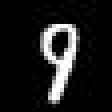

In [10]:
let 
    index_to_look_at = 1;
    training_image_dictionary[index_to_look_at] |> x-> Gray.(x);
end

Next, vectorize the images stored in the `training_image_dictionary::Dict{Int64, Array{Gray{N0f8},2}}` dictionary:
* _What do we mean by vectorize_? Each $n\times{n}$ image contains the grayscale values at each pixel. We convert these arrays into an $n^{2}$ vector of values. The converted data is stored in the `training_image_dataset::Dict{Int64, Vector{Float32}}` dictionary.
* _What's the deal with Float32_? Most neural network libraries (or other machine learning calculations) use `Float32` (or lower) to save memory because of the large number of parameters associated with the network. Additionally, model training is often carried out using specialized hardware [such as Graphical Processing Units (GPUs)](https://www.nvidia.com/en-us/data-center/h100/), which has different memory constraints.

In [12]:
training_image_dataset = let
    training_image_dataset = Dict{Int, Vector{Float32}}();
    number_of_training_examples = length(training_image_dictionary);
    for t ∈ 1:number_of_training_examples
        X = training_image_dictionary[t];
        D = Array{Float32,1}(undef, number_of_pixels);
        linearindex = 1;
        for row ∈ 1:number_of_rows
            for col ∈ 1:number_of_cols
                D[linearindex] = X[row,col];
                linearindex+=1;
            end
        end
        training_image_dataset[t] = D;
    end
    training_image_dataset
end;

### Initialized the weights and bias terms
Now let's set up _initial_ weights (and bias terms) for the model from images encoded in the `training_image_dataset::Dict{Int64, Vector{Float32}}` dictionary. 

[A Boltzmann machine](https://en.wikipedia.org/wiki/Boltzmann_machine) does _not_ use the Hebbian learning rule of the Hopfield network. However, let's generate an initial guess of the weights (and bias) using the Hopfield network. The weights $w_{ij}\in\mathbf{W}$ are given by (for a single image):
$$
\begin{equation*}
\mathbf{W} = \mathbf{s}\otimes\mathbf{s}^{\top}
\end{equation*}
$$
where $\mathbf{s}$ denotes the pixel pattern of the image that we want to learn, and [$\otimes$ denotes the _outer product_](https://en.wikipedia.org/wiki/Outer_product), i.e., $w_{ij} = s_{i}{s}_{j}$. 

Select an image from the `training_image_dataset::Dict{Int64, Vector{Float32}}` dictionary and convert it to a binary vector $s_{i}\in\{-1,1\}$, where $s_{i}=-1$ for black pixels and $s_{i}=1$ for white pixels. Save this vector in the `sₒ::Vector{Int64}` variable. 

In [14]:
sₒ = let

    example_image_index = 1; # select an image from the training dataset 
    s = Array{Int64,1}(undef, number_of_pixels);
    image = training_image_dataset[example_image_index];

    for i ∈ 1:number_of_pixels
        pixel = image[i] |> round;
        if pixel == 0.0
            s[i] = -1;
        else
            s[i] = 1;
        end
    end    
    s; # return
end;

Compute the weight matrix $\mathbf{W}$ and bias vector $\mathbf{b}$. Compute the outer product of the vector $s_{o}$ with itself. The resulting weight matrix $\mathbf{W}$ is a square matrix of size $n\times{n}$, where $n$ is the size (number of pixels) of the image. The bias term is a random number between a lower $L$ and upper $U$ bound.

In [16]:
Wₒ,b = let
    
    # initialize -
    b = Array{Float32,1}(undef,number_of_pixels); # initialize some space for the bias terms
    
    # weights
    W = sₒ*transpose(sₒ) .|> Int32 # outer product
    Wₒ = W - diagm(diag(W)); # remove the diagonal terms
    

    # bias terms
    L = -1.0; # lower bound
    U = 1.0; # upper bound
    for i ∈ 1:number_of_pixels
        f = rand();
        b[i] = f*U+(1-f)*L;
    end
    Wₒ, b
end;

__Check__: Is the weight matrix $\mathbf{W}$ symmetric? 

In [18]:
transpose(Wₒ) ≈ Wₒ

true

## Architecture
A [Boltzmann Machine](https://en.wikipedia.org/wiki/Boltzmann_machine) consists of a set of binary units (neurons, nodes, vertices, etc.) that are fully connected, with no self-connections. 

* _Nodes in a Boltzmann machine_? Each node can be in one of two states: `on` or `off.` The units have bias terms and are connected to every other node in the network with non-negative weighted edges. The state of each unit is determined by the states of the other units and the weights of the connections. The state of a node is a random variable.

Formally, [a Boltzmann Machine](https://en.wikipedia.org/wiki/Boltzmann_machine) $\mathcal{B}$ is an fully connected _undirected weighted graph_ defined by the tuple $\mathcal{B} = \left(\mathcal{V},\mathcal{E}, \mathbf{W},\mathbf{b}, \mathbf{s}\right)$.
* __Units__: Each unit (vertex, node, neuron) $v_{i}\in\mathcal{V}$ has a binary state (`on` or `off`) and a bias value 
$b_{i}\in\mathbb{R}$, where $b_{i}$ is the bias of the node $v_{i}$. The bias vector $\mathbf{b}\in\mathbb{R}^{|\mathcal{V}|}$ is the vector of bias values for all nodes in the network. 
* __Edges__: Each edge $e\in\mathcal{E}$ has a weight. The weight of the edge connecting $v_{i}\in\mathcal{V}$ and $v_{j}\in\mathcal{V}$, is denoted by $w_{ij}\in\mathbf{W}$, where the weight matrix $\mathbf{W}\in\mathbb{R}^{|\mathcal{V}|\times|\mathcal{V}|}$ is symmetric, i.e. $w_{ij} = w_{ji}$ and $w_{ii} = 0$ (no self loops). The weights $w_{ij}\in\mathbb{R}$ determine the strength of the connection between the two nodes. 
* __States__: The state of each node is represented by a binary vector $\mathbf{s}\in\mathbb{R}^{|\mathcal{V}|}$, where $s_{i}\in\{-1,1\}$ is the state of node $v_{i}$. When $s_{i} = 1$, the node is `on`, and when $s_{i} = -1$, the node is `off`. The set of all possible state _configurations_ is denoted by $\mathcal{S} \equiv \left\{\mathbf{s}^{(1)},\mathbf{s}^{(2)},\ldots,\mathbf{s}^{(N)}\right\}$, where $N$ is the number of possible state configurations, or $N = 2^{|\mathcal{V}|}$ for binary units.

## Stochastic Dynamics
Suppose we let the state of the Boltzmann Machine $\mathcal{B}$ evolve over $t=1,2,\dots, T$ turns. During each turn, every node can update its state based on the states of other nodes, the weights of its connections, and its bias term. The total input to node $v_{i}$ at turn $t$ denoted as $h_{i}^{(t)}$ is given by:
$$
h_{i}^{(t)} = \sum_{j\in\mathcal{V}} w_{ij}s_{j}^{(t-1)} + b_{i}\quad\forall i\in\mathcal{V}
$$
where $h_{i}^{(t)}$ is the total input to node $v_{i}$ at time $t$, $w_{ij}$ is the weight of the edge connecting $v_{i}$ and $v_{j}$, and $s_{j}^{(t-1)}$ is the state of node $v_{j}$ at turn $t-1$. However, unlike [classical Hopfield networks](https://en.wikipedia.org/wiki/Hopfield_network), where the update is deterministic, in a Boltzmann Machine, the state of each node is updated stochastically. The probability that node $v_{i}$ is `on` at turn $t$ is given by the logistic function:
$$
P(s_{i}^{(t)} = 1|h_{i}^{(t)}) = \frac{1}{1+\exp(-\beta\cdot{h}_{i}^{(t)})}
$$
where $P(s_{i}^{(t)} = 1|h_{i}^{(t)})$ is the probability that node $v_{i}$ is `on` at time $t$ given the total input $h_{i}^{(t)}$. The probability that node $v_{i}$ is `off` at time $t$ is given by $P(s_{i}^{(t)} = -1|h_{i}^{(t)}) = 1 - P(s_{i}^{(t)} = 1|h_{i}^{(t)})$.  
* _What is β_? The parameter $\beta$ is the (inverse) temperature parameter that controls the amount of randomness in the system. As $\beta\rightarrow\infty$, the Boltzmann Machine becomes more deterministic; however, as $\beta\rightarrow{0}$, the Boltzmann Machine becomes more random. 

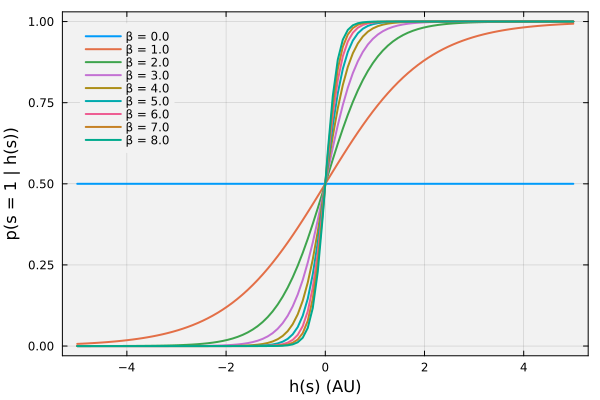

In [21]:
let 
    number_of_steps = 100;
    h = range(-5, stop=5, length=number_of_steps) |> collect;
    p = Array{Float64,1}(undef, number_of_steps);
    βa = range(0.0,stop=8,step=1) |> collect


    q = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
    for i ∈ eachindex(βa)
        β = βa[i]
        for j ∈ 1:number_of_steps
            p[j] = 1/(1+exp(-β*h[j]));
        end
        plot!(h,p, label="β = $(β)", lw=2);
    end
    current();
    xlabel!("h(s) (AU)", fontsize=18);
    ylabel!("p(s = 1 | h(s))", fontsize=18); 
end


## Stationary Distribution
After a _sufficiently large_ number of turns, the network configurations (state vectors) $\mathbf{s}^{(1)},\mathbf{s}^{(2)},\dots,$ of the Boltzmann Machine will converge to a _stationary distribution_ over the state configurations $\mathbf{s}\in\mathcal{S}$ which can be modeled as [a Boltzmann distribution](https://en.wikipedia.org/wiki/Boltzmann_distribution) of the form:
$$
P(\mathbf{s}) = \frac{1}{Z(\mathcal{S},\beta)}\exp\left(-\beta\cdot{E(\mathbf{s})}\right)
$$
where $E(\mathbf{s})$ is the energy of state $\mathbf{s}$, the $\beta$ is the (inverse) temperature of the system, and $Z(\mathcal{S},\beta)$ is the partition function. The energy of configuration $\mathbf{s}\in\mathcal{S}$ is given by:
$$
E(\mathbf{s}) = -\sum_{i\in\mathcal{V}} b_{i}s_{i} - \frac{1}{2}\sum_{i,j\in\mathcal{V}} w_{ij}s_{i}s_{j}
$$
where the first term is the energy associated with the bias terms, and the second term is the energy associated with the weights of the connections. The partition function $Z(\mathcal{S},\beta)$ is difficult to compute in practice; however, it is given by:
$$
Z(\mathcal{S},\beta) = \sum_{\mathbf{s}^{\prime}\in\mathcal{S}}\exp\left({-\beta\cdot{E}(\mathbf{s}^{\prime})}\right)
$$
where $\mathcal{S}$ is the set of _all possible network configurations_ of the Boltzmann Machine. 
* __Hmmm...__? The partition function $Z(\mathcal{S},\beta)$ is a normalizing constant that ensures that the probabilities sum to 1. However, for even a moderately sized system, the partition function is impossible to compute because it involves summing over all possible network configurations, which grows exponentially with the number of nodes. For example, in our case, that is $2^{n}$, where $n$ is the number of nodes in the network (or `2^{784}` for a $28\times{28}$ image).

If we can't compute the partition function, how do we determine if the network is in a stationary distribution? Let's look at a sampling method that allows sampling of the Boltzmann machine $\mathcal{B}$ without computing the partition function.

## Sampling from a Boltzmann Machine
To generate samples from a Boltzmann Machine, let us consider the following algorithm: 

__Initialize__ the weights $\mathbf{W}$ and biases $\mathbf{b}$ of the Boltzmann Machine. Provide an initial state $\mathbf{s}^{(0)}$ of the network, and a system temperature $\beta$.

For each turn $t=1,2,\dots,T$:
1. For each node $v_{i}\in\mathcal{V}$:
    1. Compute the total input $h_{i}^{(t)}$ to node $v_{i}$ using $h_{i}^{(t)} = \sum_{j\in\mathcal{V}} w_{ij}s_{j}^{(t-1)} + b_{i}$.
    2. Compute the probability of the _next_ state $s_{i}^{(t)} = 1$ using the logistic function $P(s_{i}^{(t)} = 1|h_{i}^{(t)}) = \left(1+\exp(-\beta\cdot{h}_{i}^{(t)})\right)^{-1}$ for node $v_{i}$. The probability of $s_{i}^{(t)} = -1$ is given by $P(s_{i}^{(t)} = -1|h_{i}^{(t)}) = 1 - P(s_{i}^{(t)} = 1|h_{i}^{(t)})$.
    3. Sample the _next_ state of node $v_{i}$ from a [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) with parameter $p = P(s_{i}^{(t)} = 1|h_{i}^{(t)})$.
2. Store the state vector $\mathbf{s}^{(t)}$ of the network at turn $t$, and proceed to the next turn.

Let's implement this algorithm and see what the simulation looks like for the black-and-white sample image we selected above.

In [24]:
T,S,E = let 
    
    model = build(MySimpleBoltzmannMachineModel, (
        W = Wₒ,
        b = b,
    ));

    # simulate the model -
    (T,S, E) = simulate(model, sₒ, T = number_of_turns, β = β);

    # return -
    T,S,E;
end;

`Unhide` the code block below to see what we save the simulation frames to disk or walk through each frame individually.

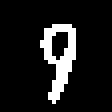

In [26]:
let
    write_frames_to_disk = false; # set to true if you want to write the frames to disk
    if write_frames_to_disk
        for i ∈ 1:number_of_turns
            filename = joinpath(_PATH_TO_FRAMES, "frame_$(i).jpg");
            img = S[:,i] |> s-> decode(s) |> img -> Gray.(img);
            FileIO.save(filename, img);
        end
    end

    S[:,1000] |> s-> decode(s) |> img -> Gray.(img)
end

### Some example movies
* __Metabstable__: We can adjust the hyperparameter $\beta$ to have the network operate in different _phases_. An example of a `metastable` simulation is [here](movies/L10a-9-beta-metastable.mp4)

In [28]:
using Base64
function display_mp4(filename)
    display("text/html", string("""<video controls><source src="data:video/mp4;base64,""", base64encode(read(filename)),"""" type="video/mp4">
</video>
"""))
end

display_mp4(joinpath(_ROOT,"movies","L10a-9-beta-metastable.mp4")) # Replace "your_video.mp4" with the actual path to your video file

<source src="data:video/mp4;base64,AAAAHGZ0eXBtcDQyAAAAAWlzb21tcDQxbXA0MgAAHxltb292AAAAbG12aGQAAAAA5AbhZOQG4WUAAF3AAA9CQAABAAABAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAACAAAXKnRyYWsAAABcdGtoZAAAAAHkBuFk5AbhZQAAAAEAAAAAAA9CQAAAAAAAAAAAAAAAAAAAAAAAAQAAAAAAAAAAAAAAAAAAAAEAAAAAAAAAAAAAAAAAAEAAAAAAHAAAABwAAAAAACRlZHRzAAAAHGVsc3QAAAAAAAAAAQAPQkAAAAAAAAEAAAAAFqJtZGlhAAAAIG1kaGQAAAAA5AbhZOQG4WUAAF3AAA9CQFXEAAAAAAAxaGRscgAAAAAAAAAAdmlkZQAAAAAAAAAAAAAAAENvcmUgTWVkaWEgVmlkZW8AAAAWSW1pbmYAAAAUdm1oZAAAAAEAAAAAAAAAAAAAACRkaW5mAAAAHGRyZWYAAAAAAAAAAQAAAAx1cmwgAAAAAQAAFglzdGJsAAAAyXN0c2QAAAAAAAAAAQAAALlhdmMxAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAABwAHABIAAAASAAAAAAAAAABAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGP//AAAALGF2Y0MBZAAU/+EAESdkABSsViww3gU4I5qDAIMBAQAEKO48sP34+AAAAAATY29scm5jbHgABgABAAYAAAAACmZpZWwBAAAAAApjaHJtAAAAAAAQcGFzcAAAAAEAAAABAAAAGHN0dHMAAAAAAAAAAQAAA+gAAAPoAAAAmHN0c3MAAAAAAAAAIgAAAAEAAAAfAAAAPQAAAFsAAAB5AAAAlwAAALUAAADTAAAA8QAAAQ8AAAEtAAABSwAAAWkAAAGHAAABpQAAAcMAAAHhAAAB/wAAAh0AAAI7AAACWQAAAncAAAKVAAACswAAAtEAAALvAAADDQAAAysAAANJAAADZwAAA4UAAAOjAAADwQAAA98AAAP0c2R0cAAAAAAgGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBgQGBAYEBggGBAYEBgQGBAYAAAAKHN0c2MAAAAAAAAAAgAAAAEAAAAYAAAAAQAAACoAAAAQAAAAAQAAD7RzdHN6AAAAAAAAAAAAAAPoAAACPgAABBYAAALOAAADUQAAA10AAAN7AAADfwAABCkAAAQSAAAD9QAABBwAAAMRAAAD1gAABIQAAAP6AAADIAAAA9sAAALnAAAC+QAAAugAAANeAAAC2gAAA9cAAAMaAAAEBQAAA4wAAAQGAAAC+AAAA8UAAAORAAAEOQAAA44AAAQgAAADYwAABBIAAANYAAAEJgAAAyUAAAPtAAADFgAAA/QAAAOBAAAEFAAAA2wAAAQOAAAC4QAABBYAAAMAAAADbQAAA10AAAPoAAADLAAAA/8AAAM2AAAEBAAAAxUAAAOsAAADVQAAA+cAAAScAAAEMwAAAxEAAAOvAAADFgAABAMAAAMqAAADvgAAAuEAAAO5AAAC0QAAA9IAAAMmAAADwgAAAxUAAAO0AAADBAAAA4IAAALpAAADeQAAAqMAAAPeAAADawAAA94AAAMuAAADrQAAA+sAAANXAAADSAAAA9cAAAM5AAAEdQAAA2gAAARCAAADpwAABCAAAAMXAAADxAAAAxEAAARLAAAC6AAAA0AAAAP4AAADhQAAA3cAAAO0AAADnAAAA+0AAAOgAAAEDgAAA0MAAAPAAAADKAAAA8IAAAM0AAAD2gAAAvsAAAPmAAACnwAAA6gAAALQAAAD8wAAAtsAAAPhAAADBgAAA+8AAAJuAAADAQAAA1EAAANUAAADIgAAA9EAAANhAAAD0QAAAp4AAAMCAAAC2AAAA50AAAL9AAADxwAAAyAAAAQEAAADKgAAAxYAAAL9AAADrAAAAwkAAAOlAAADWQAAA9kAAALIAAAEVgAAA28AAAPpAAAC5QAAA6sAAAMKAAAEQQAAAyIAAAP/AAADlAAAA/oAAAMaAAADswAAAz8AAAOvAAADcwAABEAAAANPAAAEGQAAA2QAAAPBAAADhgAABFAAAAL9AAAD7wAAAtoAAAMYAAAC/wAAA74AAAK8AAAEGQAAAx0AAAPIAAADDwAABC0AAANxAAADzAAAAvkAAAOLAAAC/gAAA70AAAKjAAADSwAAA4kAAAOYAAACqwAAAyoAAAKBAAADmQAAAtAAAAOCAAAC+wAAA+wAAAMYAAAEhgAAA1IAAAPnAAADfQAABCUAAAOKAAAENQAAAoIAAARCAAADTQAAA3EAAAMhAAADrQAAAtEAAAM/AAACjgAAA/IAAALSAAADrAAAApMAAAQJAAAC3gAAA6QAAALbAAAD/wAAAqgAAAPnAAADDQAAA5YAAAKzAAADegAAAyoAAAQvAAADcQAAA7AAAAM9AAAEtwAAAloAAAOhAAAETgAAA5UAAANjAAAD4QAAA1kAAAN/AAADUgAAA+wAAAOiAAAEBgAAAvsAAAN+AAADFAAAA0IAAAMmAAADzAAAAvUAAARcAAADRAAAA7gAAALqAAADRQAAAtwAAAPNAAAC0wAAA+gAAANDAAAE5

## Training the Boltzmann Machine
Suppose have a collection of patterns $\mathbf{X} = \left\{\mathbf{x}^{(1)},\mathbf{x}^{(2)},\ldots,\mathbf{x}^{(m)}\right\}$, where $\mathbf{x}^{(i)}\in\mathbb{R}^{|\mathcal{V}|}$ is a binary vector of size $|\mathcal{V}|$ and $m$ is the number of patterns. We want to learn the parameters of the Boltzmann Machine $\mathcal{B}$ such that the stationary distribution of the Boltzmann Machine matches the distribution of the training patterns $\mathbf{X}$.

* __Goal__: The goal of training the Boltzmann Machine is to learn the weights $\mathbf{W}$ and biases $\mathbf{b}$ of the network such that the stationary distribution of the Boltzmann Machine matches the distribution of the training patterns in the dataset $\mathbf{X}$.
* __Gradient ascent__: The learning algorithm for the Boltzmann Machine is based on gradient ascent. The idea is to adjust the weights and biases of the network in the direction of the gradient of the log-likelihood of the training patterns. This will maximize the likelihood of observing the training patterns given the weights and biases of the network.

### Training Algorithm
The training algorithm for the Boltzmann Machine maximizes the log-likelihood of observing the training patterns $x_{i}\in\mathbf{X}$ given the weights $\mathbf{W}$ and biases $\mathbf{b}$ of the network. The log-likelihood algorithm is given by:

__Initialize__: the weights $\mathbf{W}$ and biases $\mathbf{b}$ of the network to some initial guess, e.g., using the Hopfield network Hebbian learning rule. Set the learning rate $\eta$, temperature $\beta = 1$, and number of turns $T$. Precompute the data-dependent expectation $\langle{x_{i}x_{j}}\rangle_{\mathbf{X}}$ and $\langle{x_{i}}\rangle_{\mathbf{X}}$ using every training pattern $\mathbf{x}^{(i)}\in\mathbf{X}$.

1. Simulate the Boltzmann Machine $\mathcal{B}$ until it becomes stationary (or for a fixed number of turns $T$). Then, generate a set of stationary samples $\mathbf{S} = \left\{\mathbf{s}^{(1)},\mathbf{s}^{(2)},\ldots,\mathbf{s}^{(m)}\right\}$.
3. Compute the model-dependent expectation $\langle{s_{i}s_{j}}\rangle_{\mathbf{S}}$ using the stationary samples $\mathbf{s}^{(i)}\in\mathbf{S}$.
3. Update the weights of the network using the following update rule: $w_{ij}^{\prime} = w_{ij} + \Delta{w_{ij}}$ where $\Delta{w_{ij}} = \eta\left(\langle{x_{i}x_{j}}\rangle_{\mathbf{X}} - \langle{s_{i}s_{j}}\rangle_{\mathbf{S}}\right)$. The hyperparameter $\eta$ is the learning rate, $\langle{x_{i}x_{j}}\rangle_{\mathbf{X}}$ is the data-dependent expectation, and $\langle{s_{i}s_{j}}\rangle_{\mathbf{S}}$ is the model-dependent expectation. The update rule is applied to all weights in the network, i.e..., $\forall i,j\in\mathcal{V}$.
4. Update the biases of the network using the following update rule: $b_{i}^{\prime} = b_{i} + \Delta{b_{i}}$ where $\Delta{b_{i}} = \eta\left(\langle{x_{i}}\rangle_{\mathbf{X}} - \langle{s_{i}}\rangle_{\mathbf{S}}\right)$. The hyperparameter $\eta$ is the learning rate, $\langle{x_{i}}\rangle_{\mathbf{X}}$ is the data-dependent expectation, and $\langle{s_{i}}\rangle_{\mathbf{S}}$ is the model-dependent expectation. The update rule is applied to all biases in the network, i.e., $\forall i\in\mathcal{V}$.
5. Repeat steps 2-4 until convergence (or for a fixed number of iterations). 

## Lab
In Lab `L10b`, we will implement the training algorithm for the Boltzmann Machine and see if we can learn a pattern from the training data.

# Today?
That's a wrap! What are some of the interesting things we discussed today?